# **Preparing data**

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aminedjaboub","key":"54737c86528f659296267e7ddbe0c29f"}'}

In [2]:
import os
import shutil
# Create the kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)
# Move kaggle.json to the correct location
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
# Set the correct permissions
os.chmod('/root/.kaggle/kaggle.json', 600)


In [3]:
!pip install kaggle

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

100%|██████████| 1.78G/1.78G [00:17<00:00, 108MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2


In [5]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2"

# List all files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(os.path.join(root, file))


/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-01.csv
/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2015-01.csv
/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-03.csv
/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-02.csv


# **Preparing Dependencies**

In [6]:
!pip install dask memory_profiler pandas pyarrow fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import dask.dataframe as dd
import time
from memory_profiler import memory_usage

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Profiling**

**Chunk size:**

In [8]:
def process_in_chunks(file_path, chunk_size):
    start_time = time.time()
    mem_usage = memory_usage((pd.read_csv, (file_path,), {'chunksize': chunk_size}))
    total_time = time.time() - start_time
    avg_memory = max(mem_usage)

    return total_time, avg_memory

file_path = f"{dataset_path}/yellow_tripdata_2016-01.csv"
time_taken_chunk, memory_used_chunk = process_in_chunks(file_path,1000)
print(f"Pandas Chunking - Time: {time_taken_chunk:.2f} sec, Memory: {memory_used_chunk:.2f} MB")

Pandas Chunking - Time: 0.09 sec, Memory: 240.59 MB


**DASK:**

In [9]:
def process_with_dask(file_path):
    start_time = time.time()
    mem_usage = memory_usage((dd.read_csv, (file_path,)))
    total_time = time.time() - start_time
    avg_memory = max(mem_usage)

    return total_time, avg_memory

time_taken_dask, memory_used_dask = process_with_dask(file_path)
print(f"Dask - Time: {time_taken_dask:.2f} sec, Memory: {memory_used_dask:.2f} MB")


Dask - Time: 0.23 sec, Memory: 241.38 MB


**Data Compression:**

In [10]:
!pip install pyarrow fastparquet

In [11]:
df = pd.read_csv(file_path)
df.to_parquet(f"{dataset_path}/data1.parquet", compression="snappy")

print("Conversion completed!")


Conversion completed!


In [13]:
def process_parquet(file_path):
    start_time = time.time()
    mem_usage = memory_usage((pd.read_parquet, (file_path,)))
    total_time = time.time() - start_time
    avg_memory = max(mem_usage)

    return total_time, avg_memory

parquet_path = f"{dataset_path}/data1.parquet"
time_taken_parquet, memory_used_parquet = process_parquet(parquet_path)
print(f"Parquet Compression - Time: {time_taken_parquet:.2f} sec, Memory: {memory_used_parquet:.2f} MB")

Parquet Compression - Time: 8.59 sec, Memory: 6220.14 MB


# **Result Comparison**

In [14]:
results = pd.DataFrame({
    "Method": ["Pandas Chunking", "Dask", "Parquet Compression"],
    "Time (sec)": [time_taken_chunk, time_taken_dask, time_taken_parquet],
    "Memory (MB)": [memory_used_chunk, memory_used_dask, memory_used_parquet]
})

print(results)

                Method  Time (sec)  Memory (MB)
0      Pandas Chunking    0.092212   240.589844
1                 Dask    0.230181   241.378906
2  Parquet Compression    8.585033  6220.140625


**Visual Results**

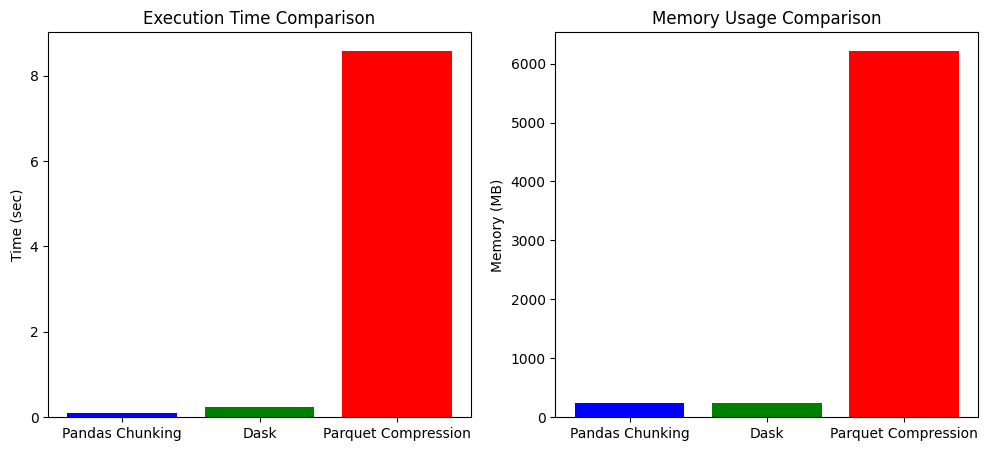

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Time comparison
ax[0].bar(results["Method"], results["Time (sec)"], color=["blue", "green", "red"])
ax[0].set_title("Execution Time Comparison")
ax[0].set_ylabel("Time (sec)")

# Memory comparison
ax[1].bar(results["Method"], results["Memory (MB)"], color=["blue", "green", "red"])
ax[1].set_title("Memory Usage Comparison")
ax[1].set_ylabel("Memory (MB)")

plt.show()